In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

Running on TPU  ['10.16.136.186:8470']


In [3]:
!pip install sentencepiece
!pip install keras_bert

In [4]:
import pandas as pd
import sentencepiece as spm
import numpy as np

# feature.csvは上記で用意したファイルのパスを指定してください
train_features_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bert/data/trains/features.csv')

def _get_indice(feature):
    tokens = []
    tokens.append('[CLS]')
    tokens.extend(sp.encode_as_pieces(feature))
    tokens.append('[SEP]')
    number = len(tokens)

    return number

sp = spm.SentencePieceProcessor()
# ダウンロードした事前学習モデルのパスを指定してください
sp.Load('/content/drive/My Drive/Colab Notebooks/bert/bert-wiki-ja/wiki-ja.model')

numbers = []

for feature in train_features_df['feature']:
    features_number = _get_indice(feature)
    numbers.append(features_number)

# 平均トークン数
max_token_num = np.max(numbers)
print("mean_token_number: " + str(max_token_num))

mean_token_number: 1478


In [5]:
import sys
sys.path.append('modules')

# BERTのロード
config_path = '/content/drive/My Drive/Colab Notebooks/bert/bert-wiki-ja/bert_finetuning_config.json'
# 拡張子まで記載しない
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/bert/bert-wiki-ja/model.ckpt-1400000'

SEQ_LEN = 512
BATCH_SIZE = 128
BERT_DIM = 768
LR = 1e-4
# 学習回数
EPOCH = 500

maxlen = SEQ_LEN

In [6]:
from keras.utils.np_utils import to_categorical
import numpy as np
import csv

sp = spm.SentencePieceProcessor()
sp.Load('/content/drive/My Drive/Colab Notebooks/bert/bert-wiki-ja/wiki-ja.model')

def _get_indice(feature):
    indices = np.zeros((maxlen), dtype = np.int32)

    tokens = []
    tokens.append('[CLS]')
    tokens.extend(sp.encode_as_pieces(feature))
    tokens.append('[SEP]')

    for t, token in enumerate(tokens):
        if t >= maxlen:
            indices[0:maxlen-1]=indices[1:maxlen]
            try:
                indices[maxlen-1] = sp.piece_to_id(token)
            except:
                indices[maxlen-1] = sp.piece_to_id('<unk>')
        else:
            try:
                indices[t] = sp.piece_to_id(token)
            except:
                indices[t] = sp.piece_to_id('<unk>')

    return indices

def _load_labeldata(train_dir, test_dir):
    t = []
    c = 0
    with open('/content/drive/My Drive/Colab Notebooks/bert/data/trains/features.csv') as f:
      for text in csv.reader(f):
        if(c!=0):
          t.append(str(text))
        c+=1
    train_features_df = pd.DataFrame(t,columns=['feature'])
    train_labels_df = pd.read_csv(f'{train_dir}/labels.csv',dtype = 'str')
    t = []
    c = 0
    with open('/content/drive/My Drive/Colab Notebooks/bert/data/tests/features.csv') as f:
      for text in csv.reader(f):
        if(c!=0):
          t.append(str(text))
        c+=1
    test_features_df = pd.DataFrame(t,columns=['feature'])
    test_labels_df = pd.read_csv(f'{test_dir}/labels.csv',dtype = 'str')
    label2index = {k: i for i, k in enumerate(train_labels_df['label'].unique())}
    index2label = {i: k for i, k in enumerate(train_labels_df['label'].unique())}
    class_count = len(label2index)
    train_labels = to_categorical([label2index[label] for label in train_labels_df['label']], num_classes=class_count)
    test_label_indices = [label2index[label] for label in test_labels_df['label']]
    test_labels = to_categorical(test_label_indices, num_classes=class_count)

    train_features = []
    test_features = []

    for feature in train_features_df['feature']:
        train_features.append(_get_indice(feature))
    train_segments = np.zeros((len(train_features), maxlen), dtype = np.float32)
    for feature in test_features_df['feature']:
        test_features.append(_get_indice(feature))
    test_segments = np.zeros((len(test_features), maxlen), dtype = np.float32)

    print(f'Trainデータ数: {len(train_features_df)}, Testデータ数: {len(test_features_df)}, ラベル数: {class_count}')

    return {
        'class_count': class_count,
        'label2index': label2index,
        'index2label': index2label,
        'train_labels': train_labels,
        'test_labels': test_labels,
        'test_label_indices': test_label_indices,
        'train_features': np.array(train_features),
        'train_segments': np.array(train_segments),
        'test_features': np.array(test_features),
        'test_segments': np.array(test_segments),
        'input_len': maxlen
    }

In [7]:
from keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten, GlobalMaxPooling1D
from keras_bert.layers import MaskedGlobalMaxPool1D
from keras import Input, Model
from keras_bert import load_trained_model_from_checkpoint


def _create_model(input_shape, class_count):

    bert = load_trained_model_from_checkpoint(config_path, checkpoint_path, training=True,  trainable=False, seq_len=SEQ_LEN)

    bert_last = bert.get_layer(name='NSP-Dense').output
    x1 = bert_last
    output_tensor = Dense(class_count, activation='sigmoid')(x1)
 
    model = Model([bert.input[0], bert.input[1]], output_tensor)

    return model

In [8]:
import tensorflow as tf
import os

# TPUの各種セットアップ
tpu_grpc_url = "grpc://" + os.environ["COLAB_TPU_ADDR"]
tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)
strategy = tf.distribute.TPUStrategy(tpu_cluster_resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.16.136.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.136.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [9]:
# データロードとモデルの準備
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras_bert import AdamWarmup, calc_train_steps

trains_dir = '/content/drive/My Drive/Colab Notebooks/bert/data/trains'
tests_dir = '/content/drive/My Drive/Colab Notebooks/bert/data/tests'

data = _load_labeldata(trains_dir, tests_dir)
model_filename = '/content/drive/My Drive/Colab Notebooks/bert/models/youtube_finetuning.h5'

decay_steps, warmup_steps = calc_train_steps(
    data['train_features'].shape[0],
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
)

with strategy.scope():
    model = _create_model(data['train_features'].shape, data['class_count'])
    model.compile(loss='binary_crossentropy',
                  optimizer=AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=LR), 
                  metrics=['mae', 'mse', 'acc'])

model.summary()

Trainデータ数: 5880, Testデータ数: 2395, ラベル数: 2
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 512)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 512, 768), ( 24576000    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 512, 768)     1536        Input-Segment[0][0]              
______________________________________________

In [10]:
history = model.fit([data['train_features'], data['train_segments']],
          data['train_labels'],
          epochs = EPOCH,
          batch_size = BATCH_SIZE,
          validation_data=([data['test_features'], data['test_segments']], data['test_labels']),
          shuffle=True,
          verbose = 1)

model.save_weights(model_filename)

Epoch 1/500
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


 2/46 [>.............................] - ETA: 3:38 - loss: 0.9295 - mae: 0.5080 - mse: 0.3304 - acc: 0.4688WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0035s vs `on_train_batch_end` time: 0.1343s). Check your callbacks.


46/46 [==============================] - ETA: 0s - loss: 0.9445 - mae: 0.5137 - mse: 0.3367 - acc: 0.4507WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0055s vs `on_test_batch_end` time: 0.1251s). Check your callbacks.


46/46 [==============================] - 44s 965ms/step - loss: 0.9445 - mae: 0.5137 - mse: 0.3367 - acc: 0.4507 - val_loss: 1.0328 - val_mae: 0.5446 - val_mse: 0.3683 - val_acc: 0.3495
Epoch 2/500
46/46 [==============================] - 9s 199ms/step - loss: 0.9407 - mae: 0.5138 - mse: 0.3358 - acc: 0.4507 - val_loss: 1.0251 - val_mae: 0.5445 - val_mse: 0.3667 - val_acc: 0.3495
Epoch 3/500
46/46 [==============================] - 9s 197ms/step - loss: 0.9314 - mae: 0.5137 - mse: 0.3337 - acc: 0.4505 - val_loss: 1.0120 - val_mae: 0.5442 - val_mse: 0.3639 - val_acc: 0.3495
Epoch 4/500
46/46 [==============================] - 9s 199ms/step - loss: 0.9212 - mae: 0.5142 - mse: 0.3315 - acc: 0.4502 - val_loss: 0.9947 - val_mae: 0.5435 - val_mse: 0.3600 - val_acc: 0.3495
Epoch 5/500
46/46 [==============================] - 9s 199ms/step - loss: 0.9049 - mae: 0.5137 - mse: 0.3274 - acc: 0.4503 - val_loss: 0.9725 - val_mae: 0.5423 - val_mse: 0.3546 - val_acc: 0.3495
Epoch 6/500
46/46 [=======

In [11]:
df = pd.DataFrame(history.history)
display(df)

,loss,mae,mse,acc,val_loss,val_mae,val_mse,val_acc
0,0.944531,0.513726,0.336729,0.450680,1.032817,0.544610,0.368305,0.349478
1,0.940724,0.513751,0.335819,0.450680,1.025125,0.544481,0.366722,0.349478
2,0.931441,0.513691,0.333674,0.450510,1.012036,0.544183,0.363944,0.349478
3,0.921154,0.514249,0.331540,0.450170,0.994717,0.543531,0.360021,0.349478
4,0.904934,0.513713,0.327399,0.450340,0.972542,0.542287,0.354608,0.349478
...,...,...,...,...,...,...,...,...
495,0.644839,0.457114,0.227077,0.621769,0.626855,0.447307,0.218518,0.653027
496,0.642655,0.455929,0.226150,0.621088,0.626818,0.447280,0.218501,0.652610
497,0.642042,0.456040,0.225964,0.616667,0.626837,0.447294,0.218510,0.652610
498,0.644595,0.457299,0.227098,0.619218,0.626835,0.447292,0.218509,0.652610


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
from keras_bert import get_custom_objects

with strategy.scope():
    model = _create_model(data['test_features'].shape, data['class_count'])
    model.load_weights(model_filename)

predicted_test_labels = model.predict([data['test_features'], data['test_segments']]).argmax(axis=1)
numeric_test_labels = np.array(data['test_labels']).argmax(axis=1)

report = classification_report(numeric_test_labels, predicted_test_labels, output_dict=True,target_names=data['index2label'].values())

display(pd.DataFrame(report).T)

,precision,recall,f1-score,support
0,0.715815,0.772786,0.743210,1558.00000
1,0.503506,0.428913,0.463226,837.00000
accuracy,0.652610,0.652610,0.652610,0.65261
macro avg,0.609660,0.600849,0.603218,2395.00000
weighted avg,0.641617,0.652610,0.645362,2395.00000


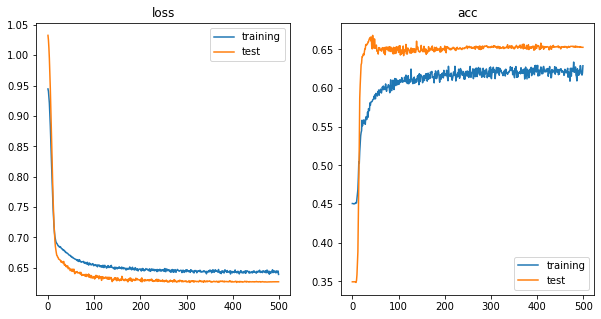

In [13]:
import matplotlib.pyplot as plt

metrics = ['loss', 'acc']  # 使用する評価関数を指定
 
plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意
 
for i in range(len(metrics)):
 
    metric = metrics[i]
 
    plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分け、i+1番目のスペースを使う
    plt.title(metric)  # グラフのタイトルを表示
    
    plt_train = history.history[metric]  # historyから訓練データの評価を取り出す
    plt_test = history.history['val_' + metric]  # historyからテストデータの評価を取り出す
    
    plt.plot(plt_train, label='training')  # 訓練データの評価をグラフにプロット
    plt.plot(plt_test, label='test')  # テストデータの評価をグラフにプロット
    plt.legend()  # ラベルの表示
    
plt.show()  # グラフの表示